# Discrete Elastic Rods
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

In [2]:
!pip install import-ipynb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00


In [3]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [4]:
def signedAngle(u = None,v = None,n = None):
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle
    return angle

In [5]:
def rotateAxisAngle(v = None,z = None,theta = None):
    if (theta == 0):
        vNew = v
    else:
        c = np.cos(theta)
        s = np.sin(theta)
        vNew = c * v + s * np.cross(z,v) + np.dot(z,v) * (1.0 - c) * z

    return vNew

In [6]:
def parallel_transport(u = None,t1 = None,t2 = None):

    # This function parallel transports a vector u from tangent t1 to t2
    # Input:
    # t1 - vector denoting the first tangent
    # t2 - vector denoting the second tangent
    # u - vector that needs to be parallel transported
    # Output:
    # d - vector after parallel transport

    b = np.cross(t1,t2)
    if (np.linalg.norm(b) == 0):
        d = u
    else:
        b = b / np.linalg.norm(b)
        # The following four lines may seem unnecessary but can sometimes help
        # with numerical stability
        b = b - np.dot(b,t1) * t1
        b = b / np.linalg.norm(b)
        b = b - np.dot(b,t2) * t2
        b = b / np.linalg.norm(b)
        n1 = np.cross(t1,b)
        n2 = np.cross(t2,b)
        d = np.dot(u,t1) * t2 + np.dot(u,n1) * n2 + np.dot(u,b) * b

    return d

In [7]:
def crossMat(a):
    A=np.matrix([[0,- a[2],a[1]],[a[2],0,- a[0]],[- a[1],a[0],0]])
    return A

#Functions to calculate reference twist and curvature

In [8]:
def computeReferenceTwist(a1e, a1f, t1, t2, refTwist = None):
    if refTwist is None:
      refTwist = 0
    P_a1e = parallel_transport(a1e, t1, t2)
    P_a1e_t = rotateAxisAngle(P_a1e, t2, refTwist)
    refTwist = refTwist + signedAngle(P_a1e_t, a1f, t2)
    return refTwist

In [9]:
def getRefTwist(a1, tangent, refTwist = None):

    # Given all the reference frames along the rod, we calculate the reference
    # twist along the rod on every node.

    ne = a1.shape[0] # ne is number of edges. Shape of a1 is ne x 3
    nv = ne + 1  # nv is number of nodes

    if refTwist is None: # No guess is provided
      refTwist = np.zeros(nv) # Intialize to all zeros.

    for c in np.arange(1,ne): # All internal nodes (i.e., all nodes except terminal nodes)
        a1e = a1[c-1,0:3]
        a1f = a1[c,  0:3]
        t1 =  tangent[c-1,0:3]
        t2 =  tangent[c,  0:3]
        refTwist[c] = computeReferenceTwist(a1e, a1f, t1, t2, refTwist[c])
    return refTwist

In [10]:
def computekappa(node0, node1, node2, m1e, m2e, m1f, m2f):
    t0 = (node1 - node0) / np.linalg.norm(node1 - node0)
    t1 = (node2 - node1) / np.linalg.norm(node2 - node1)

    kb = 2.0 * np.cross(t0,t1) / (1.0 + np.dot(t0,t1))
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    kappa = np.zeros(2)
    kappa[0] = kappa1
    kappa[1] = kappa2

    return kappa

In [11]:
def getKappa(q, m1, m2):
    nv = (len(q) + 1) // 4  # nv is number of nodes
    ne = nv - 1  # ne is number of edges

    kappa = np.zeros((nv, 2))  # Initialize kappa array

    for c in range(2, nv):  # Loop over edges (from second to last)

        # Extract node positions from q
        node0 = q[4*c-8:4*c-5]
        node1 = q[4*c-4:4*c-1]
        node2 = q[4*c+0:4*c+3]

        # Extract m1 and m2 for the current and previous edges
        m1e = m1[c-2,:].flatten()  # m1 vector on c-1 th edge
        # Another option is m1e = np.squeeze(np.array(m1[c-2, :]))
        m2e = m2[c-2,:].flatten()  # m2 vector on c-1 th edge
        m1f = m1[c-1,:].flatten()  # m1 vector on c th edge
        m2f = m2[c-1,:].flatten()  # m2 vector on c th edge

        # Compute local curvature at each node
        kappa_local = computekappa(node0, node1, node2, m1e, m2e, m1f, m2f)

        # Store the curvature values
        kappa[c-1, 0] = kappa_local[0]
        kappa[c-1, 1] = kappa_local[1]

    return kappa

# Functions to compute the frames (material frame and reference frame)

In [12]:
def computeTangent(q):
  # q is the DOF vector of size 4*nv - 1 = 3 * nv + ne
  nv = (len(q) + 1) // 4
  ne = nv - 1
  tangent = np.zeros((ne, 3))  # every edge has a tangent
  for c in range(ne):
    node0 = q[4*c:4*c+3]
    node1 = q[4*c+4:4*c+7]
    edge = node1 - node0
    tangent[c, :] = edge / np.linalg.norm(edge)
  return tangent

In [13]:
def computeMaterialDirectors(a1, a2, theta):
  # a1 = matrix of size ne x 3 - First reference director
  # a2 = matrix of size ne x 3
  # theta = vector of size ne (extracted from the DOF vector; every fourth element of the DOF vector)
  ne = len(theta) # Number of edges
  m1 = np.zeros_like(a1) # First material director
  m2 = np.zeros_like(a2) # Second material director
  for c in range(ne): # Loop over every edge
    cs = np.cos(theta[c])
    sn = np.sin(theta[c])
    m1[c, :] = cs * a1[c, :] + sn * a2[c, :]
    m2[c, :] = - sn * a1[c,:] + cs * a2[c, :]
  return m1, m2

In [14]:
def computeSpaceParallel(u1_first, q):
  # u1_first = first reference frame vector (arbitrary but orthonormal adapted) on the first edge
  # q is the DOF vector of size 4*nv - 1
  nv = (len(q)+1) // 4
  ne = nv -1

  tangent = computeTangent(q) # Get the tangent of each edge

  u1 = np.zeros((ne, 3)) # First reference frame director
  u2 = np.zeros((ne, 3)) # Second reference frame director

  u1_first = u1_first / np.linalg.norm(u1_first) # Ensure it is unit

  # First edge
  u1[0,:] = u1_first
  t0 = tangent[0,:]
  u2[0,:] = np.cross(t0, u1_first)
  u2[0,:] = u2[0,:] / np.linalg.norm(u2[0,:]) # Ensure it is unit

  for c in np.arange(1, ne):
    t0 = tangent[c-1,:] # "From" tangent
    t1 = tangent[c,:] # "To" tangent
    u1[c,:] = parallel_transport(u1[c-1,:], t0, t1)
    u1[c, :] = u1[c,:] / np.linalg.norm(u1[c,:]) # Ensure it is unit
    u2[c,:] = np.cross(t1, u1[c,:])
    u2[c, :] = u2[c,:] / np.linalg.norm(u2[c,:]) # Ensure it is unit

  return u1, u2

In [15]:
def computeTimeParallel(a1_old, q0, q):
  # a1_old: First time parallel frame director in "old" configuration
  # q0: "old" shape of the rod or DOF vector
  # q: "new" shape (a1 on this new shape is unknown)

  nv = (len(q)+1) // 4
  ne = nv -1

  tangent0 = computeTangent(q0) # Get the tangents in old configuration
  tangent = computeTangent(q) # Get the tangents in new configuration

  a1 = np.zeros((ne, 3)) # First time parallel frame director
  a2 = np.zeros((ne, 3)) # Second time parallel frame director

  for c in np.arange(ne): # Loop over every edge
    t0 = tangent0[c,:] # old tangent on the c-th edge
    t1 = tangent[c,:] # new tangent on the c-th edge
    a1[c,:] = parallel_transport(a1_old[c,:], t0, t1)
    a1[c,:] = a1[c,:] - np.dot(a1[c,:], t1) * t1 # Ensure it is orthogonal to t1
    a1[c, :] = a1[c,:] / np.linalg.norm(a1[c,:]) # Ensure it is unit
    a2[c, :] = np.cross(t1, a1[c,:])
    a2[c,:] = a2[c,:] - np.dot(a2[c,:], t1) * t1 # Ensure it is orthogonal to t1
    a2[c, :] = a2[c,:] / np.linalg.norm(a2[c,:]) # Ensure it is unit

  return a1, a2

# Gradients and Hessians of Elastic Energies

In [16]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

In [17]:
def gradEb_hessEb(node0 = None,node1 = None,node2 = None,m1e = None,m2e = None,m1f = None,m2f = None,kappaBar = None,l_k = None, EI1 = None, EI2 = None):

# This function follows the formulation by Panetta et al. 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "turning" node
# node1: 1x3 vector - position of the "turning" node
# node2: 1x3 vector - position of the node after the "turning" node

# m1e: 1x3 vector - material director 1 of the edge prior to turning
# m2e: 1x3 vector - material director 2 of the edge prior to turning
# m1f: 1x3 vector - material director 1 of the edge after turning
# m2f: 1x3 vector - material director 2 of the edge after turning

# kappaBar: 1x2 vector - natural curvature at the turning node
# l_k: voronoi length (undeformed) of the turning node
# EI1: scalar - bending stiffness for kappa1
# EI2: scalar - bending stiffness for kappa2

# Outputs:
# dF: 11x1  vector - gradient of the bending energy at node1.
# dJ: 11x11 vector - hessian of the bending energy at node1.

    # If EI2 is not specified, set it equal to EI1
    if EI2 == None:
        EI2 = EI1

    #
    ## Computation of gradient of the two curvatures
    #
    gradKappa = np.zeros((11,2))

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))
    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    tilde_d1 = (m1e + m1f) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvatures
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    Dkappa1De = 1.0 / norm_e * (- kappa1 * tilde_t + np.cross(tf,tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (- kappa1 * tilde_t - np.cross(te,tilde_d2))
    Dkappa2De = 1.0 / norm_e * (- kappa2 * tilde_t - np.cross(tf,tilde_d1))
    Dkappa2Df = 1.0 / norm_f * (- kappa2 * tilde_t + np.cross(te,tilde_d1))
    gradKappa[0:3,1-1] = - Dkappa1De
    gradKappa[4:7,1-1] = Dkappa1De - Dkappa1Df
    gradKappa[8:11,1-1] = Dkappa1Df
    gradKappa[0:3,2-1] = - Dkappa2De
    gradKappa[4:7,2-1] = Dkappa2De - Dkappa2Df
    gradKappa[8:11,2-1] = Dkappa2Df
    gradKappa[4-1,1-1] = - 0.5 * np.dot(kb,m1e)
    gradKappa[8-1,1-1] = - 0.5 * np.dot(kb,m1f)
    gradKappa[4-1,2-1] = - 0.5 * np.dot(kb,m2e)
    gradKappa[8-1,2-1] = - 0.5 * np.dot(kb,m2f)

    #
    ## Computation of hessian of the two curvatures
    #
    DDkappa1 = np.zeros((11,11)) # Hessian of kappa1
    DDkappa2 = np.zeros((11,11)) # Hessian of kappa2

    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2

    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf,tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d2t = np.transpose(tf_c_d2t_o_tt)
    kb_o_d2e = np.outer(kb, m2e)
    d2e_o_kb = np.transpose(kb_o_d2e) # Not used in Panetta 2019
    te_o_te = np.outer(te, te)
    Id3 = np.eye(3)

    # Bergou 2010
    # D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (4.0 * norm2_e) * (kb_o_d2e + d2e_o_kb)
    # Panetta 2019
    D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (2.0 * norm2_e) * (kb_o_d2e)


    tmp = np.cross(te,tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = np.transpose(te_c_d2t_o_tt)
    kb_o_d2f = np.outer(kb, m2f)
    d2f_o_kb = np.transpose(kb_o_d2f) # Not used in Panetta 2019
    tf_o_tf = np.outer( tf, tf )

    # Bergou 2010
    # D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (4.0 * norm2_f) * (kb_o_d2f + d2f_o_kb)
    # Panetta 2019
    D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (2.0 * norm2_f) * (kb_o_d2f)


    te_o_tf = np.outer(te, tf)
    D2kappa1DfDe = - kappa1 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DeDf = np.transpose(D2kappa1DfDe)

    tmp = np.cross(tf,tilde_d1)
    tf_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d1t = np.transpose(tf_c_d1t_o_tt)
    kb_o_d1e = np.outer(kb, m1e)
    d1e_o_kb = np.transpose(kb_o_d1e) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (4.0 * norm2_e) * (kb_o_d1e + d1e_o_kb)
    # Panetta 2019
    D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (2.0 * norm2_e) * (kb_o_d1e)

    tmp = np.cross(te,tilde_d1)
    te_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d1t = np.transpose(te_c_d1t_o_tt)
    kb_o_d1f = np.outer(kb, m1f)
    d1f_o_kb = np.transpose(kb_o_d1f) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (4.0 * norm2_f) * (kb_o_d1f + d1f_o_kb)
    # Panetta 2019
    D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (2.0 * norm2_f) * (kb_o_d1f)

    D2kappa2DfDe = - kappa2 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa2 * tt_o_tt + tf_c_d1t_o_tt - tt_o_te_c_d1t + crossMat(tilde_d1))
    D2kappa2DeDf = np.transpose(D2kappa2DfDe)

    D2kappa1Dthetae2 = - 0.5 * np.dot(kb,m2e)
    D2kappa1Dthetaf2 = - 0.5 * np.dot(kb,m2f)
    D2kappa2Dthetae2 = 0.5 * np.dot(kb,m1e)
    D2kappa2Dthetaf2 = 0.5 * np.dot(kb,m1f)

    D2kappa1DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m1e) * tilde_t - 1.0 / chi * np.cross(tf,m1e))
    D2kappa1DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m1f) * tilde_t - 1.0 / chi * np.cross(tf,m1f))
    D2kappa1DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m1e) * tilde_t + 1.0 / chi * np.cross(te,m1e))
    D2kappa1DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m1f) * tilde_t + 1.0 / chi * np.cross(te,m1f))
    D2kappa2DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m2e) * tilde_t - 1.0 / chi * np.cross(tf,m2e))
    D2kappa2DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m2f) * tilde_t - 1.0 / chi * np.cross(tf,m2f))
    D2kappa2DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m2e) * tilde_t + 1.0 / chi * np.cross(te,m2e))
    D2kappa2DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m2f) * tilde_t + 1.0 / chi * np.cross(te,m2f))

    # Curvature terms
    DDkappa1[0:3,0:3] = D2kappa1De2
    DDkappa1[0:3,4:7] = - D2kappa1De2 + D2kappa1DfDe
    DDkappa1[0:3,8:11] = - D2kappa1DfDe
    DDkappa1[4:7,0:3] = - D2kappa1De2 + D2kappa1DeDf
    DDkappa1[4:7,4:7] = D2kappa1De2 - D2kappa1DeDf - D2kappa1DfDe + D2kappa1Df2
    DDkappa1[4:7,8:11] = D2kappa1DfDe - D2kappa1Df2
    DDkappa1[8:11,0:3] = - D2kappa1DeDf
    DDkappa1[8:11,4:7] = D2kappa1DeDf - D2kappa1Df2
    DDkappa1[8:11,8:11] = D2kappa1Df2

    # Twist terms
    DDkappa1[4-1,4-1] = D2kappa1Dthetae2
    DDkappa1[8-1,8-1] = D2kappa1Dthetaf2

    # Curvature-twist coupled terms
    DDkappa1[0:3,4-1] = - D2kappa1DeDthetae
    DDkappa1[4:7,4-1] = D2kappa1DeDthetae - D2kappa1DfDthetae
    DDkappa1[8:11,4-1] = D2kappa1DfDthetae
    DDkappa1[4-1,0:3] = np.transpose(DDkappa1[0:3,4-1])
    DDkappa1[4-1,4:7] = np.transpose(DDkappa1[4:7,4-1])
    DDkappa1[4-1,8:11] = np.transpose(DDkappa1[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa1[0:3,8-1] = - D2kappa1DeDthetaf
    DDkappa1[4:7,8-1] = D2kappa1DeDthetaf - D2kappa1DfDthetaf
    DDkappa1[8:11,8-1] = D2kappa1DfDthetaf
    DDkappa1[8-1,0:3] = np.transpose(DDkappa1[0:3,8-1])
    DDkappa1[8-1,4:7] = np.transpose(DDkappa1[4:7,8-1])
    DDkappa1[8-1,8:11] = np.transpose(DDkappa1[8:11,8-1])

    # Curvature terms
    DDkappa2[0:3,0:3] = D2kappa2De2
    DDkappa2[0:3,4:7] = - D2kappa2De2 + D2kappa2DfDe
    DDkappa2[0:3,8:11] = - D2kappa2DfDe
    DDkappa2[4:7,0:3] = - D2kappa2De2 + D2kappa2DeDf
    DDkappa2[4:7,4:7] = D2kappa2De2 - D2kappa2DeDf - D2kappa2DfDe + D2kappa2Df2
    DDkappa2[4:7,8:11] = D2kappa2DfDe - D2kappa2Df2
    DDkappa2[8:11,0:3] = - D2kappa2DeDf
    DDkappa2[8:11,4:7] = D2kappa2DeDf - D2kappa2Df2
    DDkappa2[8:11,8:11] = D2kappa2Df2

    # Twist terms
    DDkappa2[4-1,4-1] = D2kappa2Dthetae2
    DDkappa2[8-1,8-1] = D2kappa2Dthetaf2

    # Curvature-twist coupled terms
    DDkappa2[0:3,4-1] = - D2kappa2DeDthetae
    DDkappa2[4:7,4-1] = D2kappa2DeDthetae - D2kappa2DfDthetae
    DDkappa2[8:11,4-1] = D2kappa2DfDthetae
    DDkappa2[4-1,0:3] = np.transpose(DDkappa2[0:3,4-1])
    DDkappa2[4-1,4:7] = np.transpose(DDkappa2[4:7,4-1])
    DDkappa2[4-1,8:11] = np.transpose(DDkappa2[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa2[0:3,8-1] = - D2kappa2DeDthetaf
    DDkappa2[4:7,8-1] = D2kappa2DeDthetaf - D2kappa2DfDthetaf
    DDkappa2[8:11,8-1] = D2kappa2DfDthetaf
    DDkappa2[8-1,0:3] = np.transpose(DDkappa2[0:3,8-1])
    DDkappa2[8-1,4:7] = np.transpose(DDkappa2[4:7,8-1])
    DDkappa2[8-1,8:11] = np.transpose(DDkappa2[8:11,8-1])

    #
    ## Gradient of Eb
    #
    EIMat = np.array([[EI1, 0], [0, EI2]])
    kappaVector = np.array([kappa1, kappa2])
    dkappaVector = kappaVector - kappaBar
    gradKappa_1 = gradKappa[:,0]
    gradKappa_2 = gradKappa[:,1]
    dE_dKappa1 = EI1 / l_k * dkappaVector[0] # Gradient of Eb wrt kappa1
    dE_dKappa2 = EI2 / l_k * dkappaVector[1] # Gradient of Eb wrt kappa2
    d2E_dKappa11 = EI1 / l_k # Second gradient of Eb wrt kappa1
    d2E_dKappa22 = EI2 / l_k # Second gradient of Eb wrt kappa2

    # dF is the gradient of Eb wrt DOFs
    dF = dE_dKappa1 * gradKappa_1 + dE_dKappa2 * gradKappa_2

    # Hessian of Eb
    gradKappa1_o_gradKappa1 = np.outer(gradKappa_1, gradKappa_1)
    gradKappa2_o_gradKappa2 = np.outer(gradKappa_2, gradKappa_2)
    dJ = dE_dKappa1 * DDkappa1 + dE_dKappa2 * DDkappa2 + d2E_dKappa11 * gradKappa1_o_gradKappa1 + d2E_dKappa22 * gradKappa2_o_gradKappa2

    return dF,dJ

In [18]:
def gradEt_hessEt(node0 = None,node1 = None,node2 = None,theta_e = None,
    theta_f = None,refTwist = None,twistBar = None,l_k = None,GJ = None):

# Formulation due to Panetta 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "twisting" node
# node1: 1x3 vector - position of the "twisting" node
# node2: 1x3 vector - position of the node after the "twisting" node

# theta_e: scalar - twist angle of the first edge
# theta_f: scalar - twist angle of the second (last) edge

# l_k: voronoi length (undeformed) of the turning node
# refTwist: reference twist (unit: radian) at the node
# twistBar: undeformed twist (unit: radian) at the node
# GJ: scalar - twisting stiffness

# Outputs:
# dF: 11x1  vector - gradient of the twisting energy at node1.
# dJ: 11x11 vector - hessian of the twisting energy at node1.

    gradTwist = np.zeros(11)
    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))

    # Gradient of twist wrt DOFs
    gradTwist[0:3] = - 0.5 / norm_e * kb
    gradTwist[8:11] = 0.5 / norm_f * kb
    gradTwist[4:7] = - (gradTwist[0:3] + gradTwist[8:11])
    gradTwist[4-1] = - 1
    gradTwist[8-1] = 1

    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    te_plus_tilde_t = te + tilde_t;
    kb_o_te = np.outer(kb, te_plus_tilde_t)
    te_o_kb = np.outer(te_plus_tilde_t, kb)
    tf_plus_tilde_t = tf + tilde_t
    kb_o_tf = np.outer(kb, tf_plus_tilde_t)
    tf_o_kb = np.outer(tf_plus_tilde_t, kb)
    kb_o_tilde_t = np.outer(kb, tilde_t)

    ## Hessian of twist wrt DOFs
    DDtwist = np.zeros((11,11))
    # Bergou 2010 Formulation is below.
    # D2mDe2 = - 0.25 / norm2_e * (kb_o_te + te_o_kb)
    # D2mDf2 = - 0.25 / norm2_f * (kb_o_tf + tf_o_kb)
    # D2mDeDf = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - kb_o_tilde_t)
    # D2mDfDe = np.transpose(D2mDeDf)
    # Panetta 2019 formulation
    D2mDe2 = -0.5 / norm2_e * (np.outer(kb, (te + tilde_t)) + 2.0 / chi * crossMat(tf))
    D2mDf2 = -0.5 / norm2_f * (np.outer(kb, (tf + tilde_t)) - 2.0 / chi * crossMat(te))
    D2mDfDe = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - np.outer(kb, tilde_t)) # CAREFUL: D2mDfDe means \partial^2 m/\partial e^i \partial e^{i-1}
    D2mDeDf = 0.5 / (norm_e * norm_f) * (-2.0 / chi * crossMat(tf) - np.outer(kb, tilde_t))

    # See Line 1145 of https://github.com/jpanetta/ElasticRods/blob/master/ElasticRod.cc
    DDtwist[0:3,0:3] = D2mDe2
    DDtwist[0:3,4:7] = - D2mDe2 + D2mDfDe
    DDtwist[4:7,0:3] = - D2mDe2 + D2mDeDf
    DDtwist[4:7,4:7] = D2mDe2 - (D2mDeDf + D2mDfDe) + D2mDf2
    DDtwist[0:3,8:11] = - D2mDfDe
    DDtwist[8:11,0:3] = - D2mDeDf
    DDtwist[8:11,4:7] = D2mDeDf - D2mDf2
    DDtwist[4:7,8:11] = D2mDfDe - D2mDf2
    DDtwist[8:11,8:11] = D2mDf2

    ## Gradients and Hessians of energy with respect to twist
    integratedTwist = theta_f - theta_e + refTwist - twistBar
    dE_dTau = GJ / l_k * integratedTwist
    d2E_dTau2 = GJ / l_k

    ## Gradient of Et
    dF = dE_dTau * gradTwist
    ## Hessian of Eb
    gradTwist_o_gradTwist = np.outer( gradTwist, gradTwist )
    dJ = dE_dTau * DDtwist + d2E_dTau2 * gradTwist_o_gradTwist
    return dF,dJ

#Plot the rod

In [19]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [20]:
def plotrod(q, a1, a2, m1, m2, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - a1, a2: Reference frames (director vectors).
    - m1, m2: Material directors.
    - ctime: Current time for title.
    DO NOT USE THIS PLOTTING FUNCTION.
    """

    nv = (len(q) + 1) // 4
    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    # Compute the length of the rod
    L = np.sum(np.sqrt((x1[1:] - x1[:-1])**2 +
                       (x2[1:] - x2[:-1])**2 +
                       (x3[1:] - x3[:-1])**2))

    # Scale the director vectors by 0.1 * L
    a1 *= 0.1 * L # PROBLEM!
    a2 *= 0.1 * L
    m1 *= 0.1 * L
    m2 *= 0.1 * L

    # Create figure and set up 3D plotting
    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Plot the directors along the rod
    for c in range(nv - 1):
        xa = q[4 * c : 4 * c + 3]
        xb = q[4 * c + 4 : 4 * c + 7]
        xp = (xa + xb) / 2  # Midpoint between xa and xb

        # Plot the a1, a2, m1, m2 vectors at the midpoint
        ax.plot3D([xp[0], xp[0] + a1[c, 0]], [xp[1], xp[1] + a1[c, 1]],
                  [xp[2], xp[2] + a1[c, 2]], 'b--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + a2[c, 0]], [xp[1], xp[1] + a2[c, 1]],
                  [xp[2], xp[2] + a2[c, 2]], 'c--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m1[c, 0]], [xp[1], xp[1] + m1[c, 1]],
                  [xp[2], xp[2] + m1[c, 2]], 'r-', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m2[c, 0]], [xp[1], xp[1] + m2[c, 1]],
                  [xp[2], xp[2] + m2[c, 2]], 'g-', linewidth=2)

    # Add legend
    ax.legend(['a1', 'a2', 'm1', 'm2'])

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling using the custom function
    set_axes_equal(ax)

    plt.draw()  # Force a redraw of the figure
    plt.show()

In [21]:
def plotrod_simple(q, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - ctime: Current time for title.
    """

    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling and a 3D view
    set_axes_equal(ax)
    plt.draw()  # Force a redraw of the figure

    plt.show()

# Functions to evaluate elastic forces given the DOF vector

In [22]:
def getFs(q, EA, refLen):
  # STRETCHING
  # Input q is a DOF vector of size 4*nv - 1
  # Output is the stretching force vector (size 4*nv-1) and it's gradient w.r.t. q (square matrix)
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Fs = np.zeros(ndof)
  Js = np.zeros((ndof, ndof))

  # Loop over each stretching spring
  for c in range(ne):
    xa = q[4 * c : 4 * c + 3]
    xb = q[4 * c + 4 : 4 * c + 7]
    ind = np.array([4*c, 4*c+1, 4*c+2, 4*c+4, 4*c+5, 4*c+6])
    dL = refLen[c]

    dF, dJ = gradEs_hessEs(xa, xb, dL, EA)

    Fs[ind] -= dF
    Js[np.ix_(ind, ind)] -= dJ

  return Fs, Js

In [23]:
def getFb(q, m1, m2, kappaBar, EI, voronoiRefLen):
  # BENDING
  # Input q is a DOF vector of size 4*nv - 1
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Fb = np.zeros(ndof)
  Jb = np.zeros((ndof, ndof))

  # Loop over each bending spring
  for c in range(1, ne): # Ignore the terminal nodes (0 and nv)
    node0 = q[4 * (c - 1) : 4 * (c - 1) + 3] # (c-1)-th node
    node1 = q[4 * c : 4*c + 3] # c-th node
    node2 = q[4 * (c + 1) : 4 * (c + 1) + 3] # (c+1)-th node
    # Calculate bending force due to the turning at the c-th node

    m1e = m1[c - 1, 0:3]
    m2e = m2[c - 1, 0:3]
    m1f = m1[c,  0:3]
    m2f = m2[c,  0:3]

    dL = voronoiRefLen[c]
    curvature0 = kappaBar[c, 0:2]

    dF, dJ = gradEb_hessEb(node0, node1, node2, m1e, m2e, m1f, m2f, curvature0, dL, EI)
    ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,4*c, 4*c+1, 4*c+2, 4*c+3, 4*c+4, 4*c+5, 4*c+6])

    Fb[ind] -= dF
    Jb[np.ix_(ind, ind)] -= dJ

  return Fb, Jb

In [24]:
def getFt(q, refTwist, twistBar, GJ, voronoiRefLen):
  # TWISTING
  # Input q is a DOF vector of size 4*nv - 1
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Ft = np.zeros(ndof)
  Jt = np.zeros((ndof, ndof))

  # Loop over each twisting spring
  for c in range(1, ne): # Ignore the terminal nodes (0 and nv)
    node0 = q[4 * (c - 1) : 4 * (c - 1) + 3] # (c-1)-th node
    node1 = q[4 * c : 4*c + 3] # c-th node
    node2 = q[4 * (c + 1) : 4 * (c + 1) + 3] # (c+1)-th node
    theta_e = q[4*c-1]
    theta_f = q[4*c+3]
    # Calculate twisting force due to the turning at the c-th node

    dL = voronoiRefLen[c]

    dF, dJ = gradEt_hessEt(node0, node1, node2, theta_e, theta_f, refTwist[c], twistBar[c], dL, GJ)
    ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,4*c, 4*c+1, 4*c+2, 4*c+3, 4*c+4, 4*c+5, 4*c+6])

    Ft[ind] -= dF
    Jt[np.ix_(ind, ind)] -= dJ

  return Ft, Jt

# Objective Function: Time stepping scheme

Given the old DOF, compute the new DOF

In [25]:
def objfun(qOld, uOld, a1_old, a2_old,
           freeIndex,
           dt, tol,
           refTwist,
           massVector, massMatrix,
           EA, refLen,
           EI, GJ, voronoiRefLen,
           kappaBar, twistBar,
           Fg):

  q_new = qOld.copy()
  iter = 0
  error = 10 * tol

  mu = 0.001

  while error > tol:
    # Reference frame
    a1_new, a2_new = computeTimeParallel(a1_old, qOld, q_new) # Time parallel reference frame along the rod
    # Reference twist
    tangent = computeTangent(q_new)
    refTwist_new = getRefTwist(a1_new, tangent, refTwist) # Reference twist vector of size nv
    # Material frame
    theta = q_new[3::4]
    m1, m2 = computeMaterialDirectors(a1_new, a2_new, theta) # Material directors of size nv x 3

    # Computer elastic forces
    Fs, Js = getFs(q_new, EA, refLen)
    Fb, Jb = getFb(q_new, m1, m2, kappaBar, EI, voronoiRefLen)
    Ft, Jt = getFt(q_new, refTwist_new, twistBar, GJ, voronoiRefLen)

    # Compute forces
    Forces = Fs + Fb + Ft + Fg
    JForces = Js + Jb + Jt

    f = massVector / dt * ( (q_new - qOld) / dt - uOld ) - Forces
    J = massMatrix / dt**2 - JForces

    # Extract the free part
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]

    dq_free = np.linalg.solve(J_free, f_free) # J \ f

    q_new[freeIndex] -= dq_free
    error = np.sum(np.abs(f_free)) # Correction
    # Keep in mind that "error = np.sum(np.abs(dq_free))" is ok but tol should be computed based on length
    iter += 1

  uNew = (q_new - qOld) / dt
  return q_new, uNew, a1_new, a2_new

# Main Discrete Elastic Rods

**Geometry: Create a matrix of size $N \times 3$**

In [26]:
# Inputs
nv = 50 # number of nodes
ne = nv - 1
ndof = 3*nv + ne

# Helix parameters
r0 = 0.001 # cross-sectional radius of the rod # Given, d = 0.002 m
D = 0.04 # meter: helix diameter
pitch = 2 * r0 # Pitch is the same as the cross-sectional diameter
N = 5 # Number of turns
# a and b are parameters used in standard (wikipedia) definition of helix
a = D/2 # Helix radius
b = pitch / (2.0 * np.pi)
T = 2.0 * np.pi * N # Angle created by the helix (N turns in the center)
L = T * np.sqrt( a**2 + b ** 2) # Arc length of the helix
axial_l = N * pitch # Axial length

print('Helix diameter = ', D)
print('Pitch = ', pitch)
print('N = ', N)
print('Arc length = ', L)
Estimated_Arc = np.pi * D * N
print('Estimated arc length = ', Estimated_Arc)
print('axial_l = ', axial_l)

# Create our nodes matrix
nodes = np.zeros((nv, 3))
for c in range(nv):
  t = c * T / (nv - 1.0)
  nodes[c,0] = a * np.cos(t)
  nodes[c,1] = a * np.sin(t)
  nodes[c,2] = - b * t

Helix diameter =  0.04
Pitch =  0.002
N =  5
Arc length =  0.6283981031508404
Estimated arc length =  0.6283185307179586
axial_l =  0.01


**Elastic Stiffness**

In [27]:
# Material Parameters
Y = 10e6 # 10 MPa - Young's modulus
nu = 0.5 # Poisson's ration
G = Y / ( 2 * (1 + nu)) # Shear modulus

# Stiffness variables
EA = Y * np.pi * r0**2 # Stretching stiffness
EI = Y * np.pi * r0**4 / 4.0 # Bending stiffness
GJ = G * np.pi * r0**4 / 2.0 # Twisting stiffness

**Time Parameters**

In [28]:
totalTime = 25 # seconds - total time of the simulation
dt = 0.1 # TIme step size -- may need to be adjusted

# Tolerance
tol = EI / L ** 2 * 1e-3

**Mass vector and matrix**

In [29]:
rho = 1000 # kg/m^3 -- density
totalM = L * np.pi * r0**2 * rho  # Total mass of the rod
dm = totalM / ne

massVector = np.zeros(ndof)
for c in range(nv):
  ind = [4*c, 4*c+1, 4*c+2] # x, y, z coordinates of c-th node
  if c == 0 or c == nv - 1:
    massVector[ind] = dm / 2
  else:
    massVector[ind] = dm

for c in range(ne):
  massVector[4*c+3] = 0.5 * dm * r0 ** 2 # Equation for a solid cylinder
  # Because r0 is really small, we may get away with just using 0 angular mass

massMatrix = np.diag(massVector)

**External Force: Point load on the last node (instead of gravity)**

In [30]:
F_end = EI / L ** 2
vectorLoad = np.array([0, 0, -F_end]) # Point load vector

Fg = np.zeros(ndof) # Eexternal force vector
c = nv-1
ind = [4*c, 4*c + 1, 4*c + 2] # last node
Fg[ind] += vectorLoad

**Initial DOF vector**

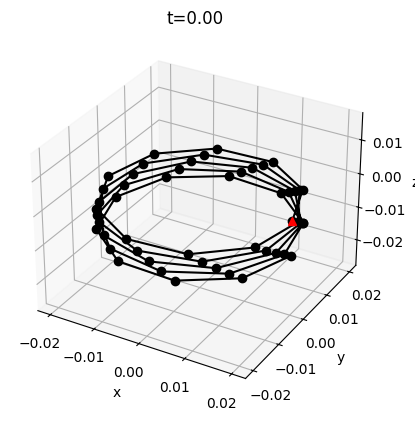

In [31]:
qOld = np.zeros(ndof)
for c in range(nv):
  ind = [4*c, 4*c + 1, 4*c + 2] # c-th node
  qOld[ind] = nodes[c, :]

uOld = np.zeros_like(qOld) # Velocity is zero initially

plotrod_simple(qOld, 0)

**Compute the reference lengths**

In [32]:
# Reference length of each edge
refLen = np.zeros(ne)
for c in range(ne):
  refLen[c] = np.linalg.norm(nodes[c + 1, :] - nodes[c, :])

voronoiRefLen = np.zeros(nv)
for c in range(nv):
  if c == 0:
    voronoiRefLen[c] = 0.5 * refLen[c]
  elif c == nv - 1:
    voronoiRefLen[c] = 0.5 * refLen[c - 1]
  else:
    voronoiRefLen[c] = 0.5 * (refLen[c - 1] + refLen[c])

**Compute the frames**

In [33]:
# Reference frame (At t=0, we initialize it with space parallel reference frame but not mandatory)
tangent = computeTangent(qOld)

t0 = tangent[0, :]
arb_v = np.array([0, 0, -1])
a1_first = np.cross(t0, arb_v) / np.linalg.norm(np.cross(t0, arb_v))
if np.linalg.norm(np.cross(t0, arb_v)) < 1e-3: # Check if t0 and arb_v are parallel
  arb_v = np.array([0, 1, 0])
  a1_first = np.cross(t0, arb_v) / np.linalg.norm(np.cross(t0, arb_v))

a1, a2 = computeSpaceParallel(a1_first, qOld)

# Material frame
theta = qOld[3::4] # Extract theta angles
m1, m2 = computeMaterialDirectors(a1, a2, theta)

In [34]:
# plotrod(qOld, a1, a2, m1, m2, 0.0) # Correction

**Natural Curvature and Twist**

In [35]:
# Reference twist
refTwist = np.zeros(nv) # Or use the function we computed

# Natural curvature
kappaBar = getKappa(qOld, m1, m2)

# Natural twist
twistBar = np.zeros(nv)

**Set up boundary conditions: First two nodes and first theta angle is fixed**

In [36]:
# Fixed and free DOFs
fixedIndex = np.arange(0, 7)
freeIndex = np.arange(7, ndof)
# If we include the x and y coordinates of the last node as FIXED DOFs, we will get better agreement

**Time stepping loop**

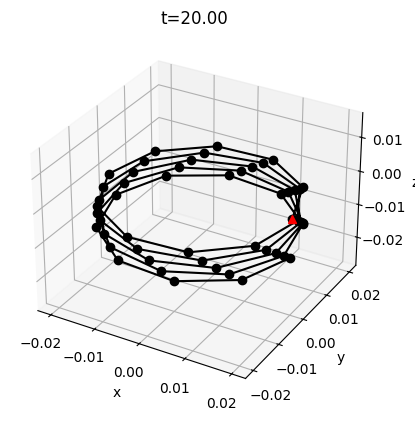

 → t = 20.100 s running step 202/250
 → t = 20.200 s running step 203/250
 → t = 20.300 s running step 204/250
 → t = 20.400 s running step 205/250
 → t = 20.500 s running step 206/250
 → t = 20.600 s running step 207/250
 → t = 20.700 s running step 208/250
 → t = 20.800 s running step 209/250
 → t = 20.900 s running step 210/250
 → t = 21.000 s running step 211/250
 → t = 21.100 s running step 212/250
 → t = 21.200 s running step 213/250
 → t = 21.300 s running step 214/250
 → t = 21.400 s running step 215/250
 → t = 21.500 s running step 216/250
 → t = 21.600 s running step 217/250
 → t = 21.700 s running step 218/250
 → t = 21.800 s running step 219/250
 → t = 21.900 s running step 220/250
 → t = 22.000 s running step 221/250
 → t = 22.100 s running step 222/250
 → t = 22.200 s running step 223/250
 → t = 22.300 s running step 224/250
 → t = 22.400 s running step 225/250
 → t = 22.500 s running step 226/250
 → t = 22.600 s running step 227/250
 → t = 22.700 s running step 228/250
 

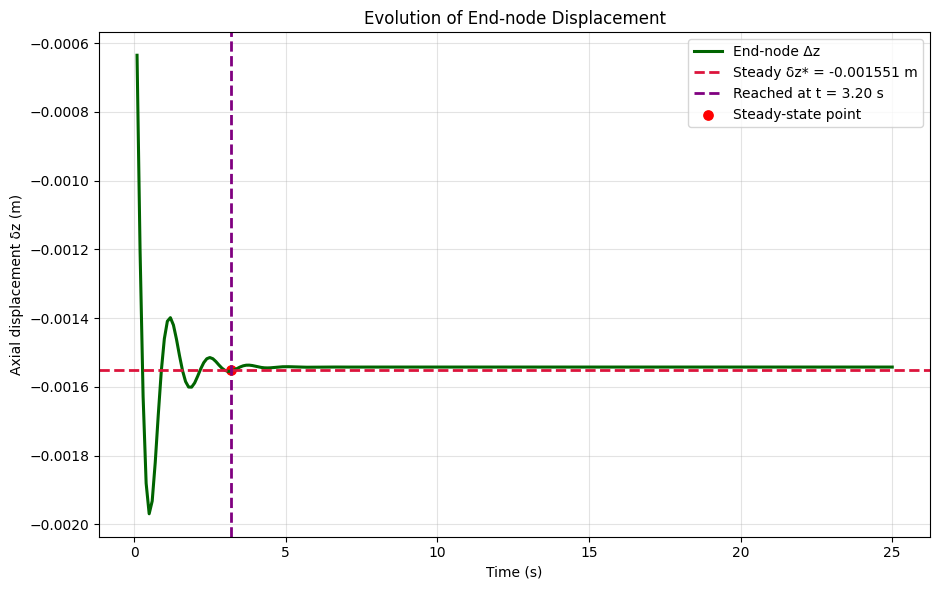

In [37]:
# -----------------------------------------
# Pre-compute number of steps and initialize
# -----------------------------------------
Nsteps = round(totalTime / dt)        # number of integration steps
ctime   = 0.0                         # time tracker
endZ_0  = qOld[-1]                    # z-position reference (initial)
endZ    = np.zeros(Nsteps)            # container for displacement history

# Save initial reference frame
a1_old = a1
a2_old = a2

# Flags for steady-state detection
steady_state_reached     = False
steady_state_time        = None
steady_state_displacement = None

# A small counter for velocity-based convergence test
vel_small_counter = 0
vel_threshold = 1e-4   # m/s  (velocity magnitude threshold)
required_duration = 0.5   # seconds that velocity must stay small


# Choose time frames for snapshots (indices only)
snapshot_times   = [0, 1, 2.5, 5, 10]
snapshot_indices = [int(t/dt) for t in snapshot_times]


# ======================================================
# --------------------- MAIN LOOP ----------------------
# ======================================================
for timeStep in range(Nsteps):

    # Print current status (cleaner style)
    print(f" → t = {ctime:.3f} s running step {timeStep+1}/{Nsteps}")

    # Run one implicit update of the rod configuration
    q_new, u_new, a1_new, a2_new = objfun(
        qOld, uOld, a1_old, a2_old,
        freeIndex, dt, tol, refTwist,
        massVector, massMatrix,
        EA, refLen,
        EI, GJ, voronoiRefLen,
        kappaBar, twistBar,
        Fg
    )

    # Track end-node displacement relative to initial
    endZ[timeStep] = q_new[-1] - endZ_0


    # ======================================================
    #     NEW Steady-state detection (velocity-based)
    # ======================================================
    if not steady_state_reached and timeStep > 3:

        # Approximate displacement time derivative (numerical velocity)
        dz_dt = (endZ[timeStep] - endZ[timeStep - 1]) / dt

        # If instantaneous velocity is very small, track how long it remains small
        if abs(dz_dt) < vel_threshold:
            vel_small_counter += 1
        else:
            vel_small_counter = 0   # Reset if velocity increases again

        # Once velocity is tiny for a sustained period → steady state
        if vel_small_counter >= int(required_duration / dt):
            steady_state_reached = True
            steady_state_time = ctime
            steady_state_displacement = endZ[timeStep]

            print("\n=== Steady-state detected (velocity method) ===")
            print(f" Time reached : {steady_state_time:.3f} s")
            print(f" δz*         : {steady_state_displacement:.6f} m")
            print(f" |dz/dt|     : {abs(dz_dt):.3e} m/s (below threshold)\n")


    # ======================================================
    #                 Save periodic snapshots
    # ======================================================
    if timeStep in snapshot_indices:

        fig = plt.figure(figsize=(7.5, 5.8))
        ax  = fig.add_subplot(111, projection='3d')

        # Node coordinates
        x1 = q_new[0::4]
        x2 = q_new[1::4]
        x3 = q_new[2::4]

        # Plot rod shape — changed colors + style
        ax.plot3D(x1, x2, x3, color='navy', marker='o', markersize=4, linewidth=1.2)
        ax.scatter(x1[0], x2[0], x3[0], c='orange', marker='^', s=60)

        # Add a time stamp (changed style)
        ax.text2D(
            0.04, 0.93, f"t = {ctime:.2f} s",
            fontsize=13, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.85, edgecolor='black')
        )

        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_zlabel("z (m)")
        ax.set_title(f"Rod Configuration @ {ctime:.2f}s")

        set_axes_equal(ax)

        # Naming convention changed
        plt.savefig(f"frame_{ctime:.2f}s_snapshot.png", dpi=280, bbox_inches='tight')
        plt.close()


    # Optional live plot (kept but restyled text)
    if timeStep % 100 == 0:
        print("   - Rendering intermediate shape...")
        plotrod_simple(q_new, ctime)


    # Prepare next iteration
    qOld   = q_new.copy()
    uOld   = u_new.copy()
    a1_old = a1_new.copy()
    a2_old = a2_new.copy()
    ctime += dt


# ======================================================
# Final displacement history plot
# ======================================================

time_array = np.arange(1, Nsteps+1) * dt
plt.figure(figsize=(9.5, 6))

plt.plot(time_array, endZ, color='darkgreen', linewidth=2.2, label='End-node Δz')

if steady_state_reached:
    plt.axhline(
        y=steady_state_displacement, linestyle='--', color='crimson',
        linewidth=2, label=f"Steady δz* = {steady_state_displacement:.6f} m"
    )
    plt.axvline(
        x=steady_state_time, linestyle='--', color='purple',
        linewidth=2, label=f"Reached at t = {steady_state_time:.2f} s"
    )
    plt.scatter(
        steady_state_time, steady_state_displacement,
        c='red', s=45, label="Steady-state point"
    )

plt.grid(alpha=0.35)
plt.xlabel("Time (s)")
plt.ylabel("Axial displacement δz (m)")
plt.title("Evolution of End-node Displacement")
plt.legend()
plt.tight_layout()
plt.savefig("displacement_evolution.png", dpi=300)
plt.show()




 Running Part (2)

Total arc length L = 6.176931e-01 m
Characteristic force F_char = 2.058470e-05 N

Load cases (logspace):
  0.0100 × F_char = 2.058470e-07 N
  0.0143 × F_char = 2.937624e-07 N
  0.0204 × F_char = 4.192259e-07 N
  0.0291 × F_char = 5.982737e-07 N
  0.0415 × F_char = 8.537913e-07 N
  0.0592 × F_char = 1.218438e-06 N
  0.0845 × F_char = 1.738823e-06 N
  0.1205 × F_char = 2.481459e-06 N
  0.1720 × F_char = 3.541270e-06 N
  0.2455 × F_char = 5.053716e-06 N
  0.3504 × F_char = 7.212115e-06 N
  0.5000 × F_char = 1.029235e-05 N

Time step dt = 1.000e-01, Nsteps = 250

--------------------------------------------
  Load case 1/12
  Applying force F = 2.058470e-07 N
--------------------------------------------

  → Steady state at t = 4.00 s
    δz* = -1.603605e-05 m
    peak-to-peak / mean = 4.800%


--------------------------------------------
  Load case 2/12
  Applying force F = 2.937624e-07 N
--------------------------------------------

  → Steady state at t = 4.00 s
   

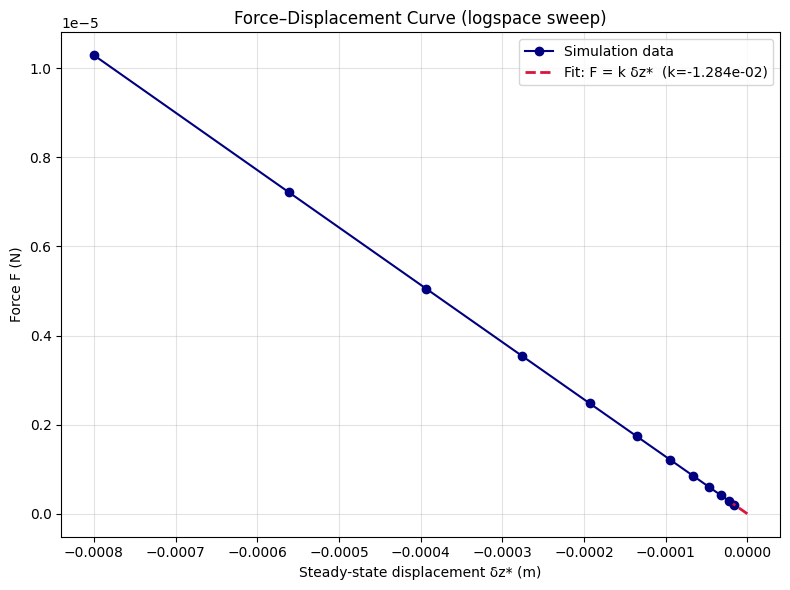

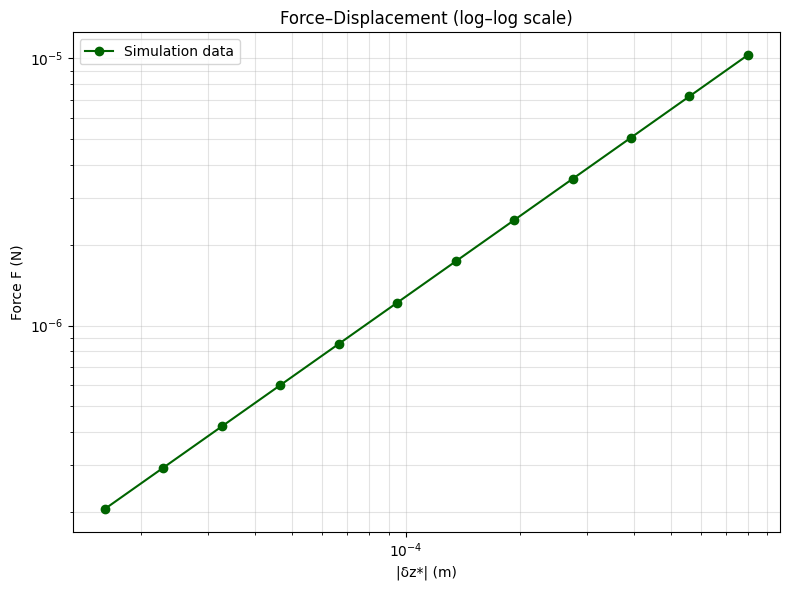


 Part (2) Completed Successfully



In [38]:
# ======================================================
# Part (2): Force–Displacement Curve with Logspace Sweep
# ======================================================

print("\n==============================")
print(" Running Part (2)")
print("==============================\n")

# ------------------------------------------------------
# 1. Characteristic force: F_char = EI / L^2, where L is
#    the arc length (as required in the updated HW spec)
# ------------------------------------------------------
L = np.sum(refLen)          # arc length from Part (1)
F_char = EI / (L**2)

print(f"Total arc length L = {L:.6e} m")
print(f"Characteristic force F_char = {F_char:.6e} N\n")

# ------------------------------------------------------
# 2. Load sweep range: 0.01 ~ 0.5 F_char (logspace).
#    The upper limit (0.5 F_char) avoids geometric
#    instability and is allowed by the assignment.
# ------------------------------------------------------
num_force_levels = 12
load_factors = np.logspace(-2, np.log10(0.5), num_force_levels)
force_values = load_factors * F_char

print("Load cases (logspace):")
for lf, Fv in zip(load_factors, force_values):
    print(f"  {lf:.4f} × F_char = {Fv:.6e} N")

# ------------------------------------------------------
# 3. Storage arrays for steady-state values
# ------------------------------------------------------
steady_displacements = np.zeros(num_force_levels)
steady_times         = np.zeros(num_force_levels)

# Reset initial configuration (do NOT use final part(1) shape)
q_init = np.zeros(ndof)
for c in range(nv):
    ind = [4*c, 4*c + 1, 4*c + 2]
    q_init[ind] = nodes[c, :]   # nodes from initial geometry
u_init = np.zeros_like(q_init)

# ======================================================
# 4. Time-stepping setup for each load case
# ======================================================
# Uses the global dt (your dt = 0.1)
totalTime_sweep = totalTime
dt_sweep        = dt
Nsteps_sweep    = round(totalTime_sweep / dt_sweep)

print(f"\nTime step dt = {dt_sweep:.3e}, Nsteps = {Nsteps_sweep}")

# ======================================================
# Loop over load values
# ======================================================
for i, F in enumerate(force_values):

    print("\n--------------------------------------------")
    print(f"  Load case {i+1}/{num_force_levels}")
    print(f"  Applying force F = {F:.6e} N")
    print("--------------------------------------------\n")

    # ---------- 4.1 Reset configuration ----------
    qOld_case  = q_init.copy()
    uOld_case  = u_init.copy()

    # Reference z-position
    endZ_0 = qOld_case[-1]
    endZ_case = np.zeros(Nsteps_sweep)

    # ---------- 4.2 Build load vector ----------
    Fg_case = np.zeros(ndof)
    vectorLoad = np.array([0.0, 0.0, -F])  # downward force along z
    c_end = nv - 1
    ind_end = [4*c_end, 4*c_end + 1, 4*c_end + 2]
    Fg_case[ind_end] += vectorLoad

    # ---------- 4.3 Recompute reference frames ----------
    tangent = computeTangent(qOld_case)
    t0 = tangent[0, :]

    arb_v = np.array([0.0, 0.0, -1.0])
    cross_tv = np.cross(t0, arb_v)
    if np.linalg.norm(cross_tv) < 1e-3:
        arb_v = np.array([0.0, 1.0, 0.0])
        cross_tv = np.cross(t0, arb_v)
    a1_first = cross_tv / np.linalg.norm(cross_tv)

    a1_case, a2_case = computeSpaceParallel(a1_first, qOld_case)
    theta_case = qOld_case[3::4]
    m1_case, m2_case = computeMaterialDirectors(a1_case, a2_case, theta_case)

    kappaBar_case = getKappa(qOld_case, m1_case, m2_case)
    refTwist_case = np.zeros(nv)
    twistBar_case = np.zeros(nv)

    a1_old_case = a1_case.copy()
    a2_old_case = a2_case.copy()

    # ---------- 4.4 Steady-state detection params ----------
    window_duration = 2.0
    window_size     = max(5, int(window_duration / dt_sweep))
    variation_tol   = 0.05          # 5% variation threshold

    steady_reached = False
    steady_disp    = None
    steady_time    = None

    # ==================================================
    # 4.5 Time integration for this load
    # ==================================================
    for step in range(Nsteps_sweep):

        ctime = (step + 1) * dt_sweep

        q_new, u_new, a1_new, a2_new = objfun(
            qOld_case, uOld_case,
            a1_old_case, a2_old_case,
            freeIndex, dt_sweep, tol, refTwist_case,
            massVector, massMatrix,
            EA, refLen,
            EI, GJ, voronoiRefLen,
            kappaBar_case, twistBar_case,
            Fg_case
        )

        endZ_case[step] = q_new[-1] - endZ_0

        # ---------- Steady-state check ----------
        if (not steady_reached) and (step >= window_size):

            window = endZ_case[step-window_size : step+1]

            mean_disp = np.mean(window)
            max_disp  = np.max(window)
            min_disp  = np.min(window)
            peak2peak = max_disp - min_disp

            if abs(mean_disp) > 1e-10:
                relative_var = peak2peak / abs(mean_disp)

                if relative_var < variation_tol:
                    steady_reached = True
                    steady_disp    = mean_disp
                    steady_time    = ctime

                    print(f"  → Steady state at t = {steady_time:.2f} s")
                    print(f"    δz* = {steady_disp:.6e} m")
                    print(f"    peak-to-peak / mean = {relative_var*100:.3f}%\n")

        # Prepare next step
        qOld_case  = q_new.copy()
        uOld_case  = u_new.copy()
        a1_old_case = a1_new.copy()
        a2_old_case = a2_new.copy()

    # ---------- 4.6 Fallback: no steady state detected ----------
    if steady_disp is None:
        steady_disp = endZ_case[-1]
        steady_time = totalTime_sweep
        print(f"  → WARNING: No steady-state detected, using final value")
        print(f"    δz* = {steady_disp:.6e} m at t = {steady_time:.2f} s\n")

    steady_displacements[i] = steady_disp
    steady_times[i]         = steady_time

# Convert to numpy array
steady_displacements = np.array(steady_displacements)

# ------------------------------------------------------
# 5. Linear fitting in small-displacement regime
# ------------------------------------------------------
linear_mask = force_values < 0.2 * F_char

F_lin  = force_values[linear_mask]
dz_lin = steady_displacements[linear_mask]

k = np.dot(F_lin, dz_lin) / np.dot(dz_lin, dz_lin)

print("\n=====================================")
print(" Linear fitting results (small region)")
print("=====================================")
print(f"Stiffness k = {k:.6e} N/m  (zero-intercept)")
print("Number of points used:", len(F_lin))
print("=====================================\n")

# ------------------------------------------------------
# 6. Plot: Force–Displacement Curve
# ------------------------------------------------------
plt.figure(figsize=(8,6))

plt.plot(steady_displacements, force_values,
         'o-', color='navy', label='Simulation data')

dz_fit = np.linspace(0, 1.1*np.max(steady_displacements), 100)
F_fit  = k * dz_fit
plt.plot(dz_fit, F_fit,
         '--', color='crimson', linewidth=2,
         label=f'Fit: F = k δz*  (k={k:.3e})')

plt.xlabel('Steady-state displacement δz* (m)')
plt.ylabel('Force F (N)')
plt.title('Force–Displacement Curve (logspace sweep)')
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.savefig('part2_force_displacement.png', dpi=300)
plt.show()

# ------------------------------------------------------
# 7. Optional: Log–log plot
# ------------------------------------------------------
plt.figure(figsize=(8,6))
plt.loglog(np.abs(steady_displacements), force_values,
           'o-', color='darkgreen', label='Simulation data')
plt.xlabel('|δz*| (m)')
plt.ylabel('Force F (N)')
plt.title('Force–Displacement (log–log scale)')
plt.grid(alpha=0.35, which='both')
plt.legend()
plt.tight_layout()
plt.savefig('part2_force_displacement_loglog.png', dpi=300)
plt.show()

print("\n==============================")
print(" Part (2) Completed Successfully")
print("==============================\n")



PART 3: DIAMETER SWEEP VS TEXTBOOK PREDICTION

Testing 10 different helix diameters from 0.0100 m to 0.0500 m
Fixed parameters: d = 0.002 m, pitch = 0.002 m, N = 5

Force multipliers range: 0.010 to 3.162
(Moderate force range to stay near linear regime and avoid numerical issues)


Diameter 1/10: D = 0.0100 m
  Arc length:   0.157398 m
  Axial length: 0.010000 m
  F_char (arc) = 3.170250e-04 N
  Force range:  3.170250e-06 to 1.002521e-03 N
  Running force sweep with 6 levels...
    Force 1/6: F = 3.170250e-06 N (0.010×F_char)... ✓ δz = -3.593947e-06 m
    Force 2/6: F = 1.002521e-05 N (0.032×F_char)... ✓ δz = -1.136129e-05 m
    Force 3/6: F = 3.170250e-05 N (0.100×F_char)... ✓ δz = -3.588986e-05 m
    Force 4/6: F = 1.002521e-04 N (0.316×F_char)... ✓ δz = -1.131162e-04 m
    Force 5/6: F = 3.170250e-04 N (1.000×F_char)... ✓ δz = -3.539191e-04 m
    Force 6/6: F = 1.002521e-03 N (3.162×F_char)... ✓ δz = -1.081528e-03 m
  → 6/6 simulations successful
  → Fitted stiffness:    k_sim = 0

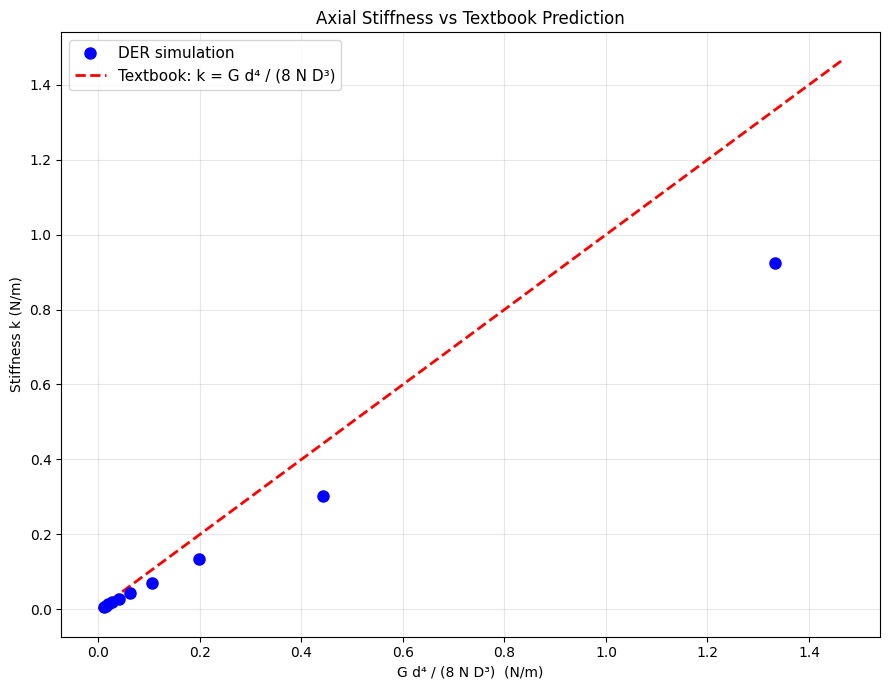

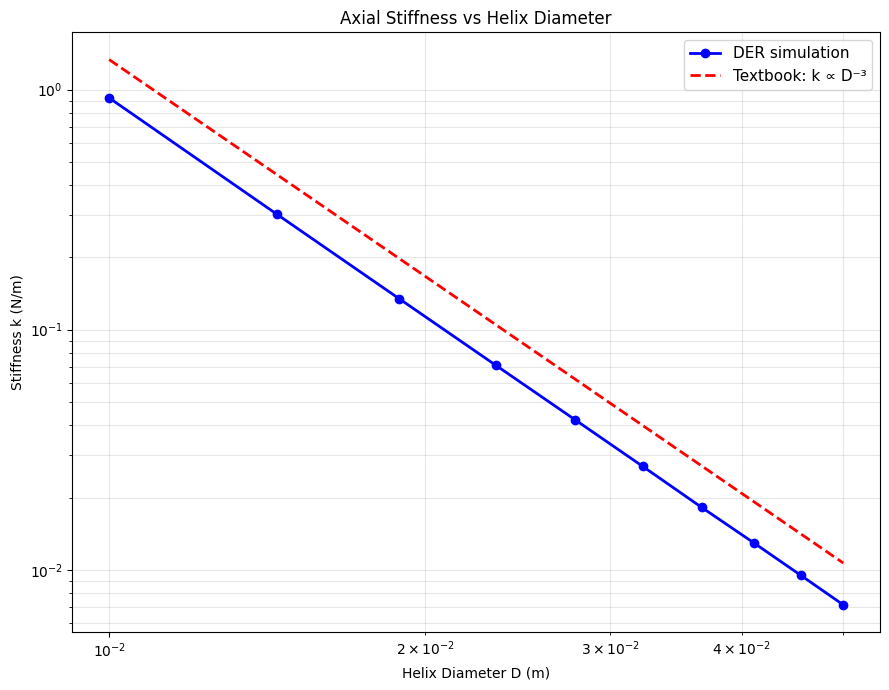

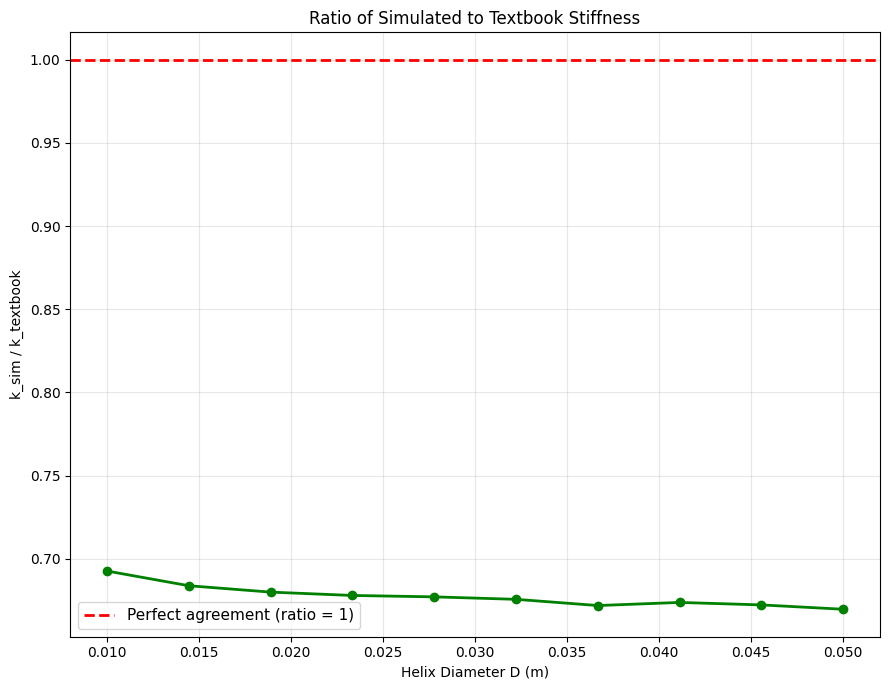

PART 3 RESULTS SUMMARY
Successfully analyzed 10/10 diameters
Diameter range: 0.0100 m to 0.0500 m

Detailed Results:
D (m)      k_sim (N/m)     k_txt (N/m)     Ratio     
--------------------------------------------------
0.0100     0.9235          1.3333          0.6926    
0.0144     0.3025          0.4424          0.6838    
0.0189     0.1345          0.1978          0.6800    
0.0233     0.0712          0.1050          0.6779    
0.0278     0.0421          0.0622          0.6771    
0.0322     0.0269          0.0399          0.6756    
0.0367     0.0182          0.0270          0.6719    
0.0411     0.0129          0.0192          0.6737    
0.0456     0.0095          0.0141          0.6723    
0.0500     0.0071          0.0107          0.6697    

Mean ratio: 0.6775
Std dev of ratio: 0.0064



In [40]:
# =============================================================================
# Helper for Part (3): run a dynamic simulation for one geometry & one load
# =============================================================================
def run_simulation_part3(
    F,
    nodes, nv, ne, ndof,
    dt_local, totalTime_local,
    window_duration, variation_tol,
    EA_local, refLen_local, EI_local, GJ_local, voronoiRefLen_local,
    massVector_local, massMatrix_local, freeIndex_local, tol_local
):
    """
    Run a dynamic relaxation for a given constant end load F and geometry
    (Part 3 use only).

    Returns
    -------
    steady_disp : float
        Steady-state axial displacement of the free end (relative to initial).
    steady_time : float
        Time at which steady state is detected, or totalTime_local if not.
    steady_reached : bool
        True if variation-based steady criterion was satisfied.
    """

    # Initial DOF vector from nodes (position only)
    qOld = np.zeros(ndof)
    for c in range(nv):
        ind = [4*c, 4*c + 1, 4*c + 2]
        qOld[ind] = nodes[c, :]
    uOld = np.zeros_like(qOld)

    # External load vector (applied at last node, downward along z)
    Fg = np.zeros(ndof)
    vectorLoad = np.array([0.0, 0.0, -F])
    c_end = nv - 1
    ind_end = [4*c_end, 4*c_end + 1, 4*c_end + 2]
    Fg[ind_end] += vectorLoad

    # Initial frames & reference curvature
    tangent = computeTangent(qOld)
    t0 = tangent[0, :]

    arb_v = np.array([0.0, 0.0, -1.0])
    cross_tv = np.cross(t0, arb_v)
    if np.linalg.norm(cross_tv) < 1e-3:
        arb_v = np.array([0.0, 1.0, 0.0])
        cross_tv = np.cross(t0, arb_v)
    a1_first = cross_tv / np.linalg.norm(cross_tv)

    a1, a2 = computeSpaceParallel(a1_first, qOld)
    theta = qOld[3::4]
    m1, m2 = computeMaterialDirectors(a1, a2, theta)

    kappaBar = getKappa(qOld, m1, m2)
    refTwist = np.zeros(nv)
    twistBar = np.zeros(nv)

    a1_old = a1.copy()
    a2_old = a2.copy()

    # Time integration settings
    Nsteps = int(round(totalTime_local / dt_local))
    endZ0 = qOld[-1]
    endZ = np.zeros(Nsteps)

    # Steady-state detection parameters
    window_size = max(5, int(window_duration / dt_local))
    steady_reached = False
    steady_disp = None
    steady_time = None

    for step in range(Nsteps):

        ctime = (step + 1) * dt_local

        q_new, u_new, a1_new, a2_new = objfun(
            qOld, uOld,
            a1_old, a2_old,
            freeIndex_local, dt_local, tol_local, refTwist,
            massVector_local, massMatrix_local,
            EA_local, refLen_local,
            EI_local, GJ_local, voronoiRefLen_local,
            kappaBar, twistBar,
            Fg
        )

        endZ[step] = q_new[-1] - endZ0

        # Variation-based steady-state criterion (same idea as Part 2)
        if (not steady_reached) and (step >= window_size):
            window = endZ[step - window_size : step + 1]

            mean_disp = np.mean(window)
            max_disp  = np.max(window)
            min_disp  = np.min(window)
            peak2peak = max_disp - min_disp

            if abs(mean_disp) > 1e-10:
                relative_var = peak2peak / abs(mean_disp)
                if relative_var < variation_tol:
                    steady_reached = True
                    steady_disp = mean_disp
                    steady_time = ctime
                    break

        # Prepare for next time step
        qOld = q_new.copy()
        uOld = u_new.copy()
        a1_old = a1_new.copy()
        a2_old = a2_new.copy()

    # Fallback if not detected as steady
    if not steady_reached:
        steady_disp = endZ[-1]
        steady_time = totalTime_local

    return steady_disp, steady_time, steady_reached


# =============================================================================
# PART 3: DIAMETER SWEEP VS TEXTBOOK PREDICTION
# =============================================================================

print("\n" + "="*80)
print("PART 3: DIAMETER SWEEP VS TEXTBOOK PREDICTION")
print("="*80 + "\n")

# Fixed parameters for the spring
r0_fixed     = 0.001            # wire radius
d_fixed      = 2.0 * r0_fixed   # wire diameter
pitch_fixed  = 0.002            # axial pitch per turn
N_fixed      = 5                # number of turns
Y_fixed      = 10e6
nu_fixed     = 0.5
G_fixed      = Y_fixed / (2.0 * (1.0 + nu_fixed))

# Range of helix diameters D
D_values    = np.linspace(0.01, 0.05, 10)
num_D_values = len(D_values)

print(f"Testing {num_D_values} different helix diameters "
      f"from {D_values[0]:.4f} m to {D_values[-1]:.4f} m")
print(f"Fixed parameters: d = {d_fixed} m, pitch = {pitch_fixed} m, N = {N_fixed}\n")

# Arrays to store stiffness results
k_values         = np.zeros(num_D_values)
textbook_values  = np.zeros(num_D_values)

# Simulation parameters for Part 3 (optimized)
dt_part3          = 0.1             # relatively large for speed (implicit solver)
totalTime_part3   = 10.0            # 10 s of physical time is enough with dt=0.1
window_duration   = 2.0             # seconds used for variation check
variation_tol     = 0.05            # 5% peak-to-peak / mean

# Force sweep parameters (scaled by characteristic force)
num_force_levels_part3   = 6
force_multipliers_part3  = np.logspace(-2, 0.5, num_force_levels_part3)  # ~0.01 to ~3.16

print(f"Force multipliers range: {force_multipliers_part3[0]:.3f} "
      f"to {force_multipliers_part3[-1]:.3f}")
print("(Moderate force range to stay near linear regime and avoid numerical issues)\n")

# -------------------------------------------------------------------------
# Loop over each helix diameter
# -------------------------------------------------------------------------
for idx, D in enumerate(D_values):
    print(f"\n{'='*60}")
    print(f"Diameter {idx+1}/{num_D_values}: D = {D:.4f} m")
    print(f"{'='*60}")

    # Geometric parameters for this helix
    a = D / 2.0
    b = pitch_fixed / (2.0 * np.pi)
    T = 2.0 * np.pi * N_fixed

    # Arc length of the helix (for F_char = EI / L^2)
    L_arc   = T * np.sqrt(a**2 + b**2)
    axial_l = N_fixed * pitch_fixed   # axial length (for info only)

    print(f"  Arc length:   {L_arc:.6f} m")
    print(f"  Axial length: {axial_l:.6f} m")

    # Discretize helix into nv_part3 nodes
    nv_part3   = 40                   # fewer nodes than 60 -> faster
    ne_part3   = nv_part3 - 1
    ndof_part3 = 3 * nv_part3 + ne_part3

    nodes_part3 = np.zeros((nv_part3, 3))
    for c in range(nv_part3):
        t = c * T / (nv_part3 - 1.0)
        nodes_part3[c, 0] = a * np.cos(t)
        nodes_part3[c, 1] = a * np.sin(t)
        nodes_part3[c, 2] = -b * t

    # Elastic stiffness parameters
    EA_part3 = Y_fixed * np.pi * r0_fixed**2
    EI_part3 = Y_fixed * np.pi * r0_fixed**4 / 4.0
    GJ_part3 = G_fixed * np.pi * r0_fixed**4 / 2.0

    # Reference segment lengths
    refLen_part3 = np.zeros(ne_part3)
    for c in range(ne_part3):
        refLen_part3[c] = np.linalg.norm(nodes_part3[c + 1, :] - nodes_part3[c, :])

    voronoiRefLen_part3 = np.zeros(nv_part3)
    for c in range(nv_part3):
        if c == 0:
            voronoiRefLen_part3[c] = 0.5 * refLen_part3[c]
        elif c == nv_part3 - 1:
            voronoiRefLen_part3[c] = 0.5 * refLen_part3[c - 1]
        else:
            voronoiRefLen_part3[c] = 0.5 * (refLen_part3[c - 1] + refLen_part3[c])

    # Mass properties
    rho_part3    = 1000.0
    totalM_part3 = L_arc * np.pi * r0_fixed**2 * rho_part3
    dm_part3     = totalM_part3 / ne_part3

    massVector_part3 = np.zeros(ndof_part3)
    for c in range(nv_part3):
        ind = [4*c, 4*c + 1, 4*c + 2]
        if c == 0 or c == nv_part3 - 1:
            massVector_part3[ind] = dm_part3 / 2.0
        else:
            massVector_part3[ind] = dm_part3

    for c in range(ne_part3):
        massVector_part3[4*c + 3] = 0.5 * dm_part3 * r0_fixed**2

    massMatrix_part3 = np.diag(massVector_part3)

    # Nonlinear solver tolerance for this geometry (using arc length)
    tol_part3 = EI_part3 / (L_arc**2) * 1e-3

    # Boundary conditions: fix first node (x,y,z,theta) and x,y,z of second node
    fixedIndex_part3 = np.arange(0, 7)
    freeIndex_part3  = np.arange(7, ndof_part3)

    # Characteristic force for this geometry (updated spec: use arc length)
    F_char_part3 = EI_part3 / (L_arc**2)

    # Force sweep for this diameter
    force_values_part3         = force_multipliers_part3 * F_char_part3
    steady_displacements_part3 = np.zeros(num_force_levels_part3)

    print(f"  F_char (arc) = {F_char_part3:.6e} N")
    print(f"  Force range:  {force_values_part3[0]:.6e} to {force_values_part3[-1]:.6e} N")
    print(f"  Running force sweep with {num_force_levels_part3} levels...")

    # Run simulations for each force level
    successful_count = 0
    for i_force, F in enumerate(force_values_part3):
        print(f"    Force {i_force+1}/{num_force_levels_part3}: "
              f"F = {F:.6e} N ({force_multipliers_part3[i_force]:.3f}×F_char)... ",
              end='')

        try:
            disp, t_steady, conv = run_simulation_part3(
                F,
                nodes_part3, nv_part3, ne_part3, ndof_part3,
                dt_part3, totalTime_part3,
                window_duration, variation_tol,
                EA_part3, refLen_part3, EI_part3, GJ_part3, voronoiRefLen_part3,
                massVector_part3, massMatrix_part3, freeIndex_part3, tol_part3
            )
            steady_displacements_part3[i_force] = disp
            successful_count += 1
            print(f"✓ δz = {disp:.6e} m")

        except Exception as e:
            print(f"✗ Failed (numerical issue: {type(e).__name__})")
            steady_displacements_part3[i_force] = np.nan
            continue

    print(f"  → {successful_count}/{num_force_levels_part3} simulations successful")

    # Check if we have enough valid data for fitting
    valid_mask = ~np.isnan(steady_displacements_part3)
    if np.sum(valid_mask) < 3:
        print(f"  → ERROR: Too few successful simulations. Skipping D = {D:.4f} m")
        k_values[idx] = np.nan
        # Still compute the textbook value for completeness
        textbook_values[idx] = G_fixed * d_fixed**4 / (8.0 * N_fixed * D**3)
        continue

    # Extract linear stiffness from valid data (zero-intercept least squares)
    F_valid     = force_values_part3[valid_mask]
    delta_valid = np.abs(steady_displacements_part3[valid_mask])

    if len(F_valid) >= 2:
        k_fitted = np.dot(F_valid, delta_valid) / np.dot(delta_valid, delta_valid)
        k_values[idx] = k_fitted
    else:
        print("  → ERROR: Insufficient data for fitting")
        k_values[idx] = np.nan

    # Textbook prediction for this diameter
    k_textbook = G_fixed * d_fixed**4 / (8.0 * N_fixed * D**3)
    textbook_values[idx] = k_textbook

    if not np.isnan(k_fitted):
        print(f"  → Fitted stiffness:    k_sim = {k_fitted:.4f} N/m")
        print(f"  → Textbook prediction: k_txt = {k_textbook:.4f} N/m")
        print(f"  → Ratio k_sim/k_txt:   {k_fitted/k_textbook:.4f}")
    else:
        print(f"  → Textbook prediction: k_txt = {k_textbook:.4f} N/m")


# -------------------------------------------------------------------------
# Post-processing: clean invalid entries and generate plots
# -------------------------------------------------------------------------
valid_D_mask         = ~np.isnan(k_values)
D_values_valid       = D_values[valid_D_mask]
k_values_valid       = k_values[valid_D_mask]
textbook_values_valid = textbook_values[valid_D_mask]

if len(D_values_valid) < 3:
    print("ERROR: Too few successful diameter values. Cannot create plots.")
else:
    # X-axis: textbook stiffness parameter G d^4 / (8 N D^3)
    textbook_param = G_fixed * d_fixed**4 / (8.0 * N_fixed * D_values_valid**3)

    # Plot 1: k_sim vs textbook parameter with reference line y=x
    plt.figure(figsize=(9, 7))
    plt.plot(textbook_param, k_values_valid, 'bo', markersize=8,
             label='DER simulation', zorder=3)

    x_line = np.linspace(0, np.max(textbook_param) * 1.1, 100)
    y_line = x_line
    plt.plot(x_line, y_line, 'r--', linewidth=2,
             label='Textbook: k = G d⁴ / (8 N D³)', zorder=2)

    plt.xlabel('G d⁴ / (8 N D³)  (N/m)')
    plt.ylabel('Stiffness k (N/m)')
    plt.title('Axial Stiffness vs Textbook Prediction')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('part3_stiffness_vs_textbook.png', dpi=300)
    plt.show()

    # Plot 2: Stiffness vs Diameter (log–log)
    plt.figure(figsize=(9, 7))
    plt.loglog(D_values_valid, k_values_valid, 'bo-', markersize=6, linewidth=2,
               label='DER simulation')
    plt.loglog(D_values_valid, textbook_values_valid, 'r--', linewidth=2,
               label='Textbook: k ∝ D⁻³')

    plt.xlabel('Helix Diameter D (m)')
    plt.ylabel('Stiffness k (N/m)')
    plt.title('Axial Stiffness vs Helix Diameter')
    plt.grid(True, alpha=0.3, which='both')
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('part3_stiffness_vs_diameter.png', dpi=300)
    plt.show()

    # Plot 3: Ratio k_sim / k_textbook
    plt.figure(figsize=(9, 7))
    ratio = k_values_valid / textbook_values_valid
    plt.plot(D_values_valid, ratio, 'go-', markersize=6, linewidth=2)
    plt.axhline(y=1.0, color='r', linestyle='--', linewidth=2,
                label='Perfect agreement (ratio = 1)')

    plt.xlabel('Helix Diameter D (m)')
    plt.ylabel('k_sim / k_textbook')
    plt.title('Ratio of Simulated to Textbook Stiffness')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('part3_stiffness_ratio.png', dpi=300)
    plt.show()

    # Console summary
    print("="*80)
    print("PART 3 RESULTS SUMMARY")
    print("="*80)
    print(f"Successfully analyzed {len(D_values_valid)}/{num_D_values} diameters")
    print(f"Diameter range: {D_values_valid[0]:.4f} m to {D_values_valid[-1]:.4f} m\n")

    print("Detailed Results:")
    print(f"{'D (m)':<10} {'k_sim (N/m)':<15} {'k_txt (N/m)':<15} {'Ratio':<10}")
    print("-" * 50)
    for i in range(len(D_values_valid)):
        print(f"{D_values_valid[i]:<10.4f} {k_values_valid[i]:<15.4f} "
              f"{textbook_values_valid[i]:<15.4f} {ratio[i]:<10.4f}")

    print(f"\nMean ratio: {np.mean(ratio):.4f}")
    print(f"Std dev of ratio: {np.std(ratio):.4f}")
    print("="*80 + "\n")
